# Supervised and unsupervised learning with kernels - practical

In this notebook, we will cover implementation details and applications for two problems:
    
* Kernel ridge regression on toy data
* Kernel principal component analysis
* Application for denoising MNIST digits


The notebook contains a number of `# IMPLEMENT` comments, where you are supposed to insert missing code yourself.
We also prepared a solution notebook that contains the code we envisioned.


In [46]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotRegression, plot_multiple_images, scatter_label_points, loadMNIST

%matplotlib inline



# Kernel Ridge Regression

## Loading data

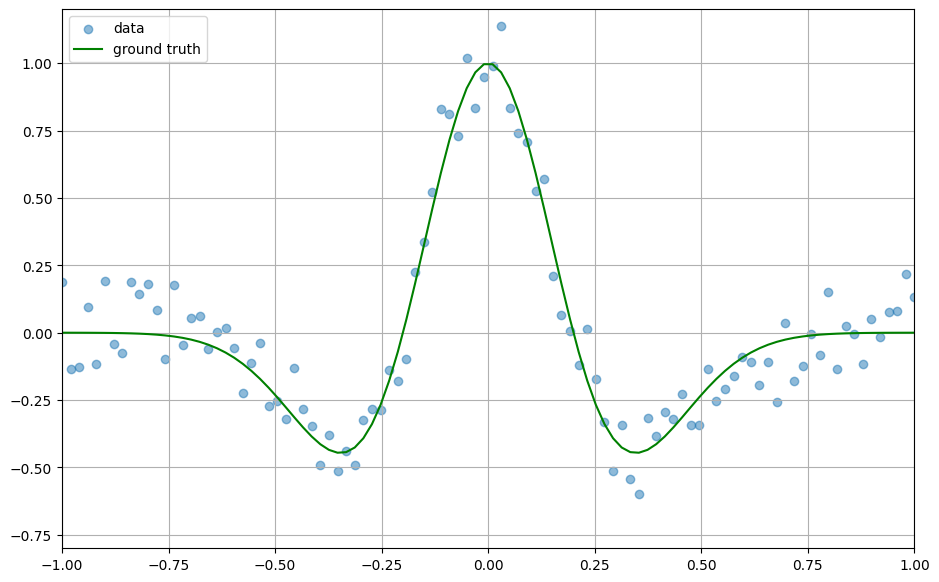

In [47]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## I- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [48]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        squared_norm = np.expand_dims(np.sum(X**2,axis=1),axis=1) + np.expand_dims(np.sum(Y**2,axis=1),axis=0)-2*np.einsum('nd,md->nm',X,Y)
        return np.exp(-0.5*squared_norm/self.sigma**2)

In [49]:
class Laplace:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        squared_norm = np.expand_dims(np.sum(X**2,axis=1),axis=1) + np.expand_dims(np.sum(Y**2,axis=1),axis=0)-2*np.einsum('ni,mi->nm',X,Y)
        return np.exp(-np.sqrt(squared_norm)/self.sigma)

In [50]:
class Linear:
    def kernel(self,X,Y):
        #squared_norm = np.expand_dims(np.sum(X**2,axis=1),axis=1) + np.expand_dims(np.sum(Y**2,axis=1),axis=0)-2*np.einsum('ni,mi->nm',X,Y)
        return np.einsum('ni,mi->nm',X,Y)

## II- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [51]:
class KernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.data = None
        self.alpha = None
        self.b = None
        self.type='ridge'
    
    def fit(self, X, y):
        if len(y.shape)==1:
            y = np.expand_dims(y, axis=1)
        N,_ = y.shape
        G = self.kernel(X, X)
        np.fill_diagonal(G, np.diag(G) + N*self.lmbda)
        U = cho_factor(G)
        sol_y = cho_solve(U, y)
        self.alpha = sol_y
        self.data = X
        
    ### Implementation of the separting function $f$ 
    def predict(self,x):
        # Input : matrix x of shape M data points times d dimension
        # Output: vector of size M
        x1 = self.kernel(self.data, x)
        pred = np.einsum('nm,nd->md',x1,self.alpha)
        if pred.shape[1]==1:
            return pred[:,0]
        else:
            return pred
    

## III - Fitting the regressor

Run the code block below to fit the regressor and report its output.

### a) Linear Kernel

In [45]:
lmbda = .1
kernel = Linear().kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

ValueError: incompatible dimensions ((200, 200) and (100, 1))

### b) Nonlinear Kernel

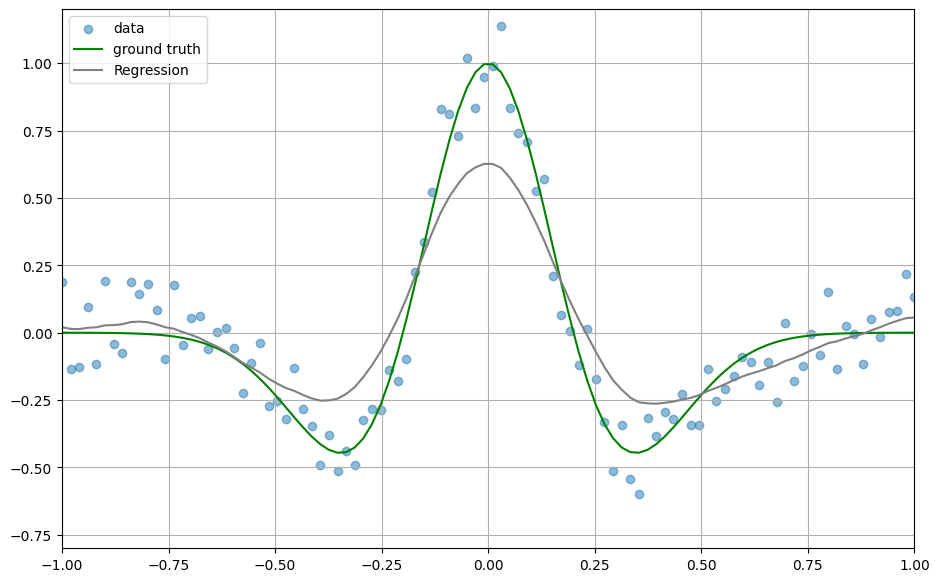

In [53]:
sigma = 10.
lmbda =0.001
offset = .0
kernel = Laplace(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y']+offset)
plotRegression(train_set['x'], train_set['y']+offset, Y_clean= train_set['y_clean']+offset, model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA


In [35]:
class KernelPCA:
    
    def __init__(self,kernel, r_min=0,r_max=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresponding to the top d eingenvalues of G
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.data = None # Data points where the features are evaluated
        self.r_max =r_max
        self.r_min = r_min
    def centered_kernel(self,X,Y):
        if self.data is None:
            raise Exception("Impossible to computed centered kernel: training data is unavailable!")
        else:
            N = self.data.shape[0]   
            G_XY = self.kernel(X,Y)
            G_XD = np.expand_dims(np.sum(self.kernel(X,self.data),axis=1),axis=1)
            G_DY = np.expand_dims(np.sum(self.kernel(self.data,Y),axis=0),axis=0)
            G_DD = np.sum(self.kernel(self.data,self.data))
            return G_XY- (1/N)*(G_XD+ G_DY) + (1/N**2)*G_DD
        
    def fit(self, X):
        self.data = X
        
        N = X.shape[0]    
        #e = 1/N*np.ones([N])
        tilde_G = self.centered_kernel(X,X)
        U,S,V = np.linalg.svd(tilde_G)
        
        self.lmbda = S[self.r_min:self.r_max]
        self.alpha = U[:,self.r_min:self.r_max]/np.sqrt(self.lmbda)
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        x1 = self.centered_kernel(self.data, x)
        return np.einsum('ij,id->jd',x1,self.alpha)
    


### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

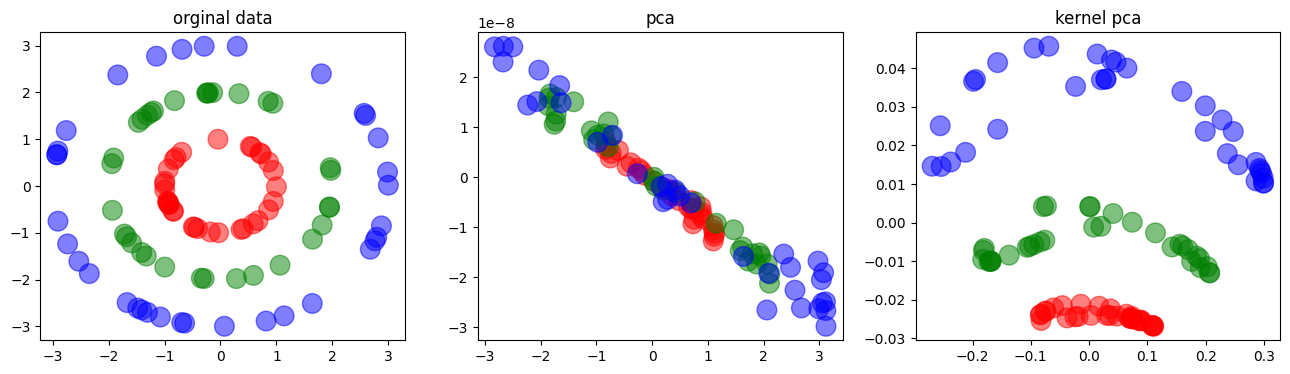

In [37]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

train_X = train_set["x"]
test_X = test_set["x"]
train_Y = train_set["y"]
test_Y = test_set["y"]


r_min = 1 ### Try different values (ex: 1)
r_max = r_min+2


kernel = Linear().kernel
pca = KernelPCA(kernel,  r_min=r_min, r_max=r_max)
pca.fit(train_X)
pca_components = pca.transform(test_X)

sigma =10.
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r_min=r_min, r_max=r_max)
pca.fit(train_X)
rbf_pca_components = pca.transform(test_X)



fig, ax = plt.subplots(1,3, figsize=(16, 4))
scatter_label_points(test_X, test_Y, ax[0], title='orginal data')
scatter_label_points(pca_components,test_Y, ax[1], title= 'pca')
scatter_label_points(rbf_pca_components,test_Y, ax[2], title= 'kernel pca')



# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [22]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r_min=0, r_max=dim_pca)
        self.ridge_reg = KernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self,train):
        flat_shape = train.shape[1]*train.shape[2]
        flat_train = train.reshape(-1,flat_shape)
        self.pca.fit(flat_train)
        flat_train = train.reshape(-1,flat_shape)
        pca_components = self.pca.transform(flat_train)
        self.ridge_reg.fit(pca_components, flat_train)
        
    def denoise(self,test):
        flat_shape = test.shape[1]*test.shape[2]
        flat_test = test.reshape(-1,flat_shape)
        pca_components_test = self.pca.transform(flat_test)
        flat_pred = self.ridge_reg.predict(pca_components_test)
        return np.reshape(flat_pred, (-1,test.shape[1],test.shape[2]))


### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successfull? How can it be improved?

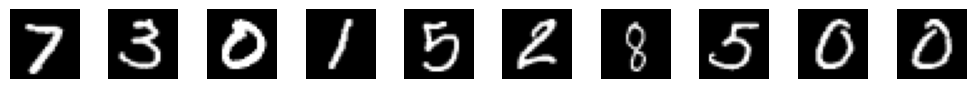

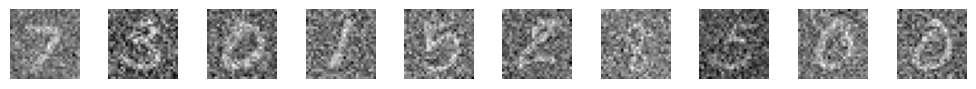

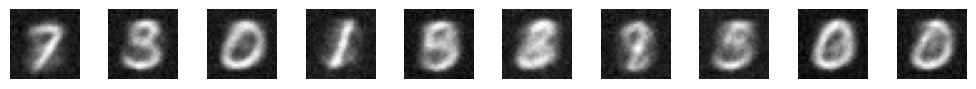

In [23]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']


dim_pca =100
lmbda = 10.
sigma_encoder =8.
sigma_decoder =.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(data['train'])
pred = denoiser.denoise(data['test'])

plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)